In [4]:
# ✅ 1. Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import seaborn as sns


In [4]:
from google.colab import files
uploaded = files.upload()


Saving breast-cancer.csv to breast-cancer (1).csv


In [5]:
# ✅ 2. Load and Prepare Dataset

# Load dataset (ensure file is in the same folder as your .ipynb or .py file)
df = pd.read_csv("breast-cancer.csv")

# Drop ID and unnamed columns if present
if 'id' in df.columns:
    df = df.drop('id', axis=1)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Encode diagnosis: M = 1 (Malignant), B = 0 (Benign)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Features and target
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [6]:
# ✅ 3. Train SVM Models (Linear and RBF Kernels)

# Linear kernel
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)

# RBF kernel
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)

# Evaluation
print("📘 Linear Kernel Performance:")
print(classification_report(y_test, y_pred_linear))
print(confusion_matrix(y_test, y_pred_linear))

print("\n📗 RBF Kernel Performance:")
print(classification_report(y_test, y_pred_rbf))
print(confusion_matrix(y_test, y_pred_rbf))


📘 Linear Kernel Performance:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96        71
           1       0.93      0.95      0.94        43

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114

[[68  3]
 [ 2 41]]

📗 RBF Kernel Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        71
           1       1.00      0.95      0.98        43

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

[[71  0]
 [ 2 41]]


In [7]:
# ✅ 4. Hyperparameter Tuning using GridSearchCV

# Tune only RBF kernel
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_train, y_train)

# Best model evaluation
print("✅ Best Parameters:", grid.best_params_)
y_pred_best = grid.predict(X_test)
print(classification_report(y_test, y_pred_best))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01

In [8]:
# ✅ 5. Cross-Validation Score
cv_score = cross_val_score(grid.best_estimator_, X, y, cv=5)
print(f"Average CV Accuracy: {np.mean(cv_score):.4f}")


Average CV Accuracy: 0.9086


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


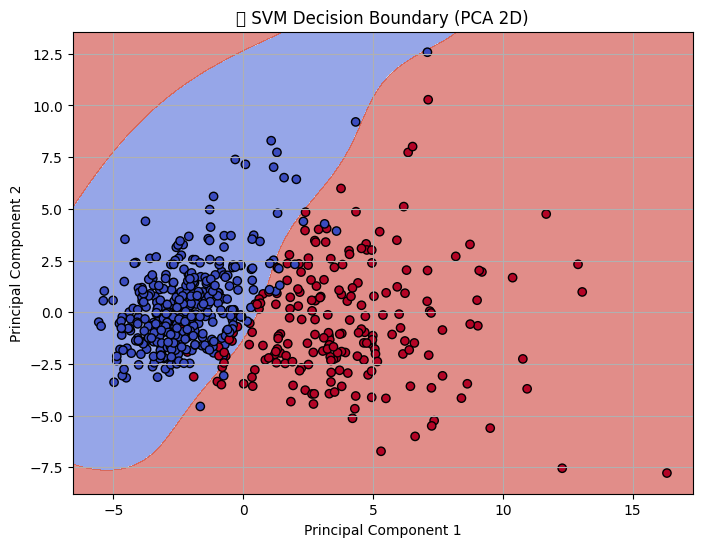

In [9]:
# ✅ 6. PCA + 2D Decision Boundary Visualization (Optional but Required in Task)

# PCA reduction to 2D
X_scaled_full = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_scaled_full)

# Train-test split for visualization
X_train_vis, X_test_vis, y_train_vis, y_test_vis = train_test_split(X_vis, y, test_size=0.2, random_state=42)

# Train SVM on PCA-reduced data
svm_vis = SVC(kernel='rbf', C=1)
svm_vis.fit(X_train_vis, y_train_vis)

# Plotting function
def plot_svm_decision_boundary(model, X, y):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.coolwarm)
    plt.title("🔍 SVM Decision Boundary (PCA 2D)")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.show()

# Show decision boundary
plot_svm_decision_boundary(svm_vis, X_vis, y)
